# Stats and Sampling

*NOTE: to generate your own sample, you can execute the **Setup**  cells and then go down to **Sampling booked searches only** *

This notebook looks at two things that are united not by theme but by the fact that I have to iterate through all the data anyway:

1. Counting the number of searches with each unique value for a given feature. I didn't look at all the features, as some have a very large number of unique values.
2. Sampling the data so we have a smaller amount that we can more easily work with.

I am able to plot the distribution of most of the features, which may be interesting/useful.

## Setup

In [1]:
import numpy as np
import pandas as pd
from math import ceil
import pickle
with open('datapath.txt') as f:
    datapath=f.readlines()[0].rstrip()



In [100]:
import matplotlib.pyplot as plt
import matplotlib

In [118]:
matplotlib.style.use('fivethirtyeight')

In [17]:
#%matplotlib qt
%matplotlib inline

In [2]:
totaltrainrows=37670293
ndestinations=62106
totaltestrows=2528243

In [3]:
with open('feature_dtypes.pkl', 'r') as f:
    featuredtypes=pickle.load(f)

In [4]:
dates=[u'srch_ci', u'srch_co','date_time']

There are some check in/check out dates that this parser can't parse that might be recoverable (ex: someone searched for a checkin date in the year 2557, which is too large for the date time format), but it mostly does a good job.

In [5]:
parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d',errors='coerce')

In [6]:
columns=pd.read_csv(datapath+'train.csv',nrows=5,dtype=featuredtypes,parse_dates=dates,date_parser=parser).columns

These features have lots of unique values, so I'm not getting count statistics for the unique vals.

In [7]:
dropped=['user_id','srch_destination_id','user_location_city','orig_destination_distance']

In [8]:
statcolumns=(columns.drop(dropped)).tolist()

## Iteration

In [83]:
nchunks=20
chunksize=ceil(totaltrainrows/nchunks)
trainit=pd.read_csv(datapath+'train.csv',chunksize=chunksize,iterator=True,dtype=featuredtypes,parse_dates=dates,date_parser=parser)

In [10]:
def df_counts(df,column,dates):
    if column in dates:
        dtdf=pd.DataFrame([df[column].dt.year,df[column].dt.month],index=['month','year']).T
        return dtdf.groupby(['year','month']).size()
    else:
        return df.groupby(column).size()

In [11]:
def addcounts(cnt,cnk,stcol,dates):
    newcnt=[df_counts(cnk,stcol[i],dates) for i in xrange(len(stcol))]
    return [cnt[i].add(newcnt[i],axis='index',fill_value=0.0) for i in xrange(len(stcol))]

In [12]:
samplerate=1.0/10

In [13]:
%%time
ichunk=0
for chunk in trainit:
    if ichunk==0:
        fullcount=[df_counts(chunk,col,dates) for col in statcolumns]
        buycount=[df_counts(chunk[chunk['is_booking']==1],col,dates) for col in statcolumns]
        sample=chunk.sample(frac=samplerate)
    else:
        fullcount=addcounts(fullcount,chunk,statcolumns,dates)
        buycount=addcounts(buycount,chunk[chunk['is_booking']==1],statcolumns,dates)
        sample=sample.append(chunk.sample(frac=samplerate),ignore_index=True)
    print(ichunk)
    ichunk+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
CPU times: user 45min 55s, sys: 32.5 s, total: 46min 28s
Wall time: 46min 27s


#### Save the data:

In [23]:
with open('fullcount.pkl','w') as f:
    pickle.dump(fullcount, f)
with open('buycount.pkl','w') as f:
    pickle.dump(buycount, f)


In [80]:
sample.to_csv(datapath+'ten_perc_total_sample.csv')

## Plotting

I tracked two different things: the full data, and the data where the booking actually occured.

In [75]:
for i in xrange(len(fullcount)):
    fullcount[i].name = statcolumns[i]
    buycount[i].name = statcolumns[i]

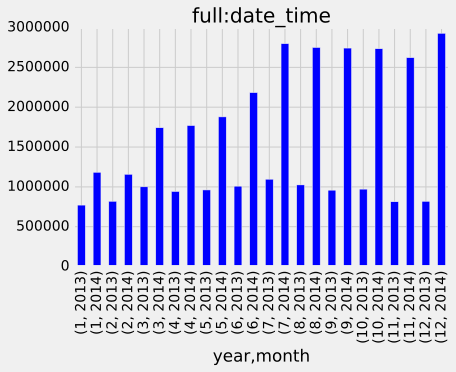

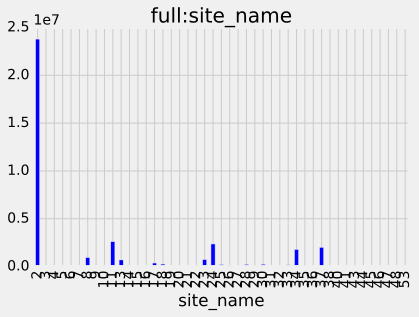

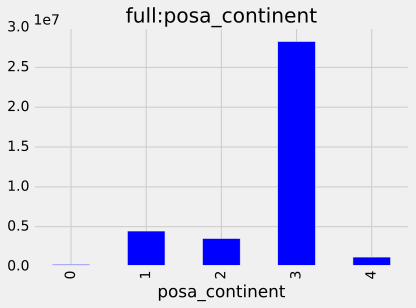

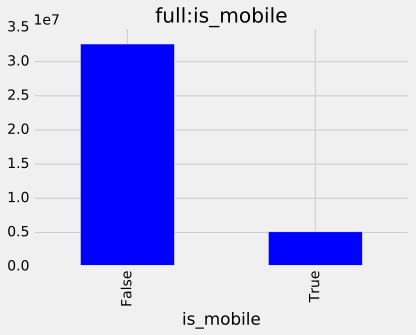

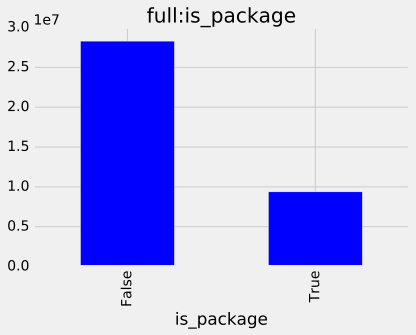

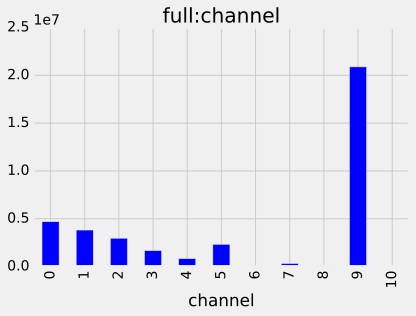

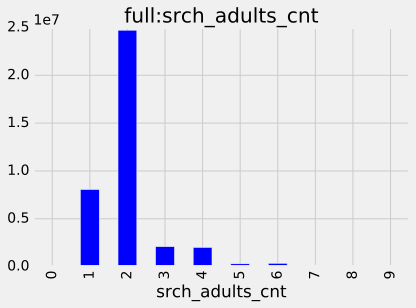

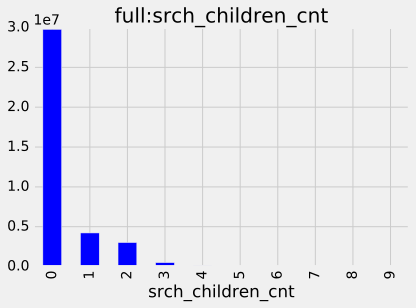

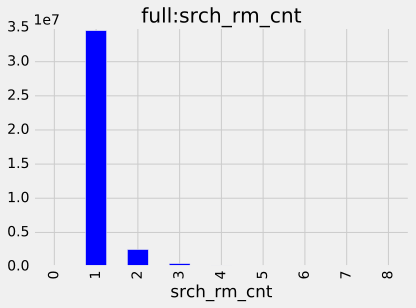

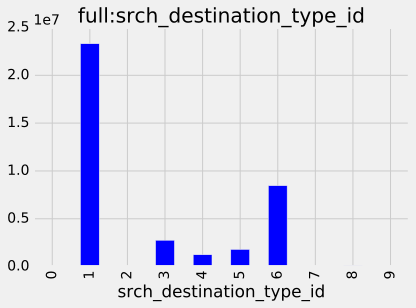

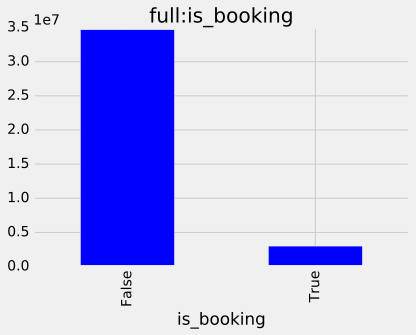

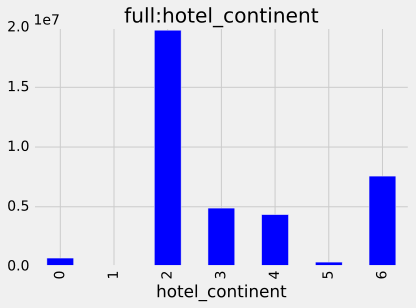

In [119]:
for i in fullcount:
    if i.shape[0] < 50:
        i.plot(kind='bar')
        plt.title('full:'+i.name)  
        plt.show()

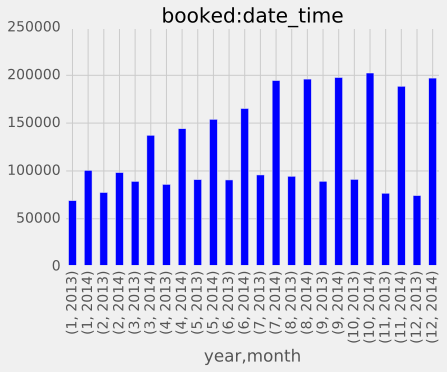

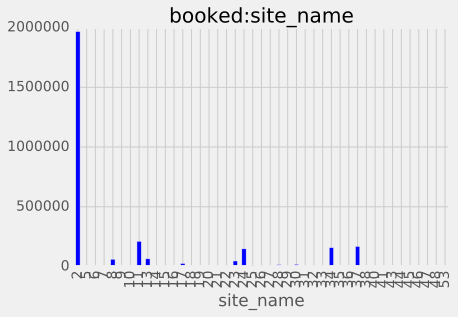

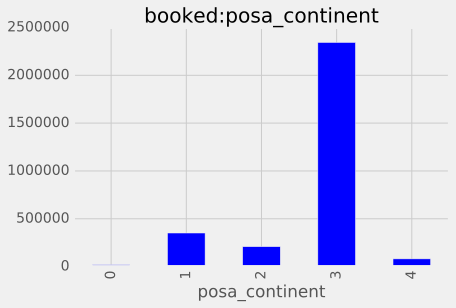

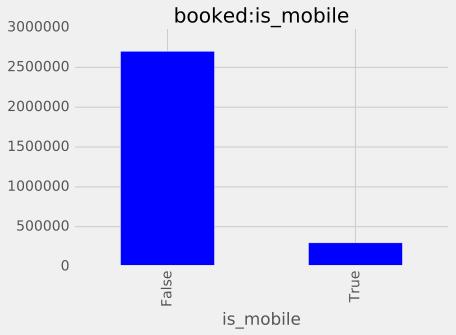

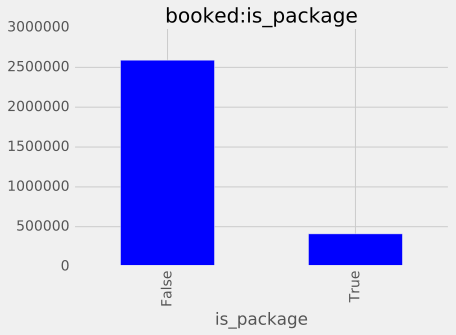

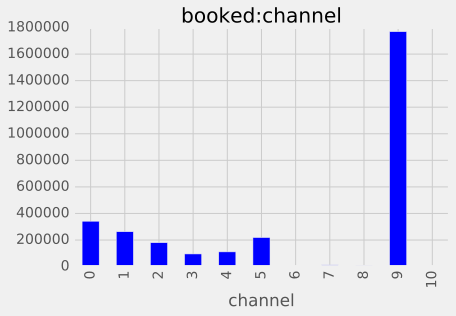

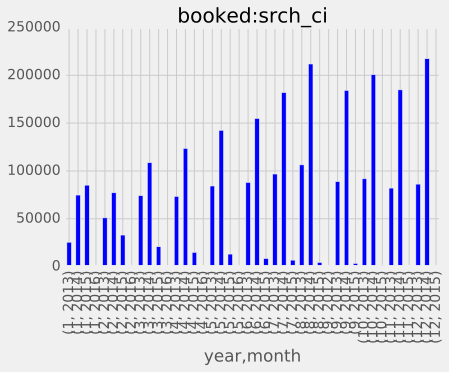

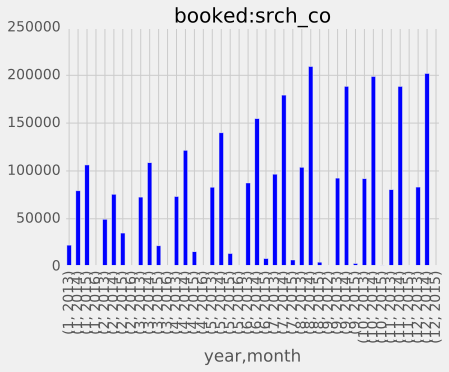

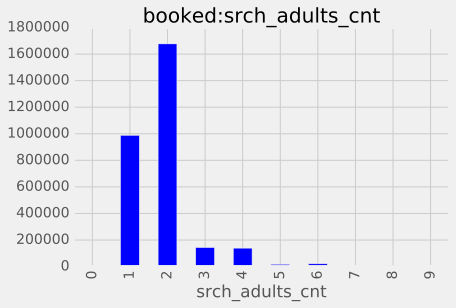

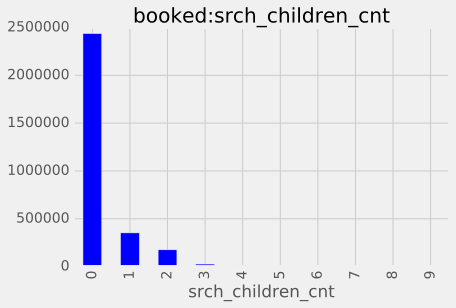

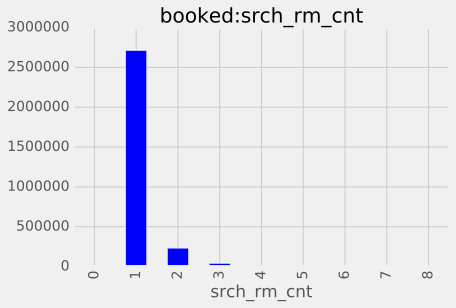

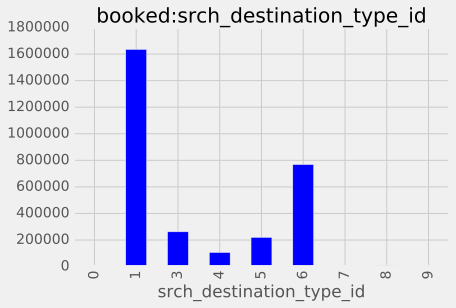

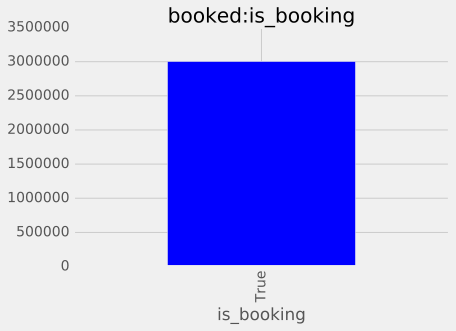

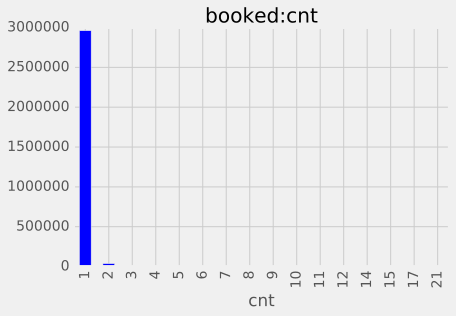

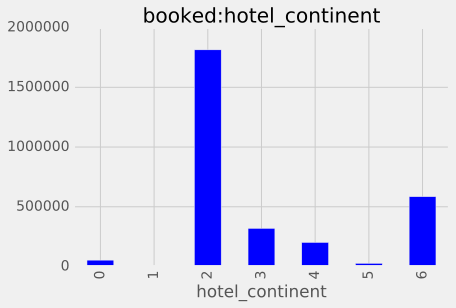

In [114]:
for i in buycount:
    if i.shape[0] < 50:
        i.plot(kind='bar')
        plt.title('booked:'+i.name)
        plt.show()

## Sampling booked searches only:

In [90]:
booking_count=fullcount[statcolumns.index('is_booking')]
float(booking_count[True])/booking_count.sum()

0.07965674702875288

Only 8% of the rows actually have a booking. It would be great if they had a session id column or something so we could match unbooked rows to the eventual booking.

We can use 1/3 of the booked data and still get a reasonable number of rows for sampling.

In [95]:
samplerate=0.3

In [96]:
%%time
trainit=pd.read_csv(datapath+'train.csv',chunksize=chunksize,iterator=True,dtype=featuredtypes,parse_dates=dates,date_parser=parser)
ichunk=0
for chunk in trainit:
    chunk=chunk[chunk['is_booking']==True]
    if ichunk==0:
        #fullcount=[df_counts(chunk,col,dates) for col in statcolumns]
        #buycount=[df_counts(chunk[chunk['is_booking']==1],col,dates) for col in statcolumns]
        sample=chunk.sample(frac=samplerate)
    else:
        #fullcount=addcounts(fullcount,chunk,statcolumns,dates)
        #buycount=addcounts(buycount,chunk[chunk['is_booking']==1],statcolumns,dates)
        sample=sample.append(chunk.sample(frac=samplerate),ignore_index=True)
    print(ichunk)
    ichunk+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
CPU times: user 1min 55s, sys: 6.81 s, total: 2min 2s
Wall time: 2min 6s


In [98]:
sample.shape

(900209, 24)

In [99]:
sample.to_csv(datapath+'thirty_perc_booked_sample.csv')

## Looking at hotel cluster

In [120]:
hotel_count = fullcount[statcolumns.index('hotel_cluster')]

In [136]:
hotel_count.sort_values(ascending=False,inplace=True)

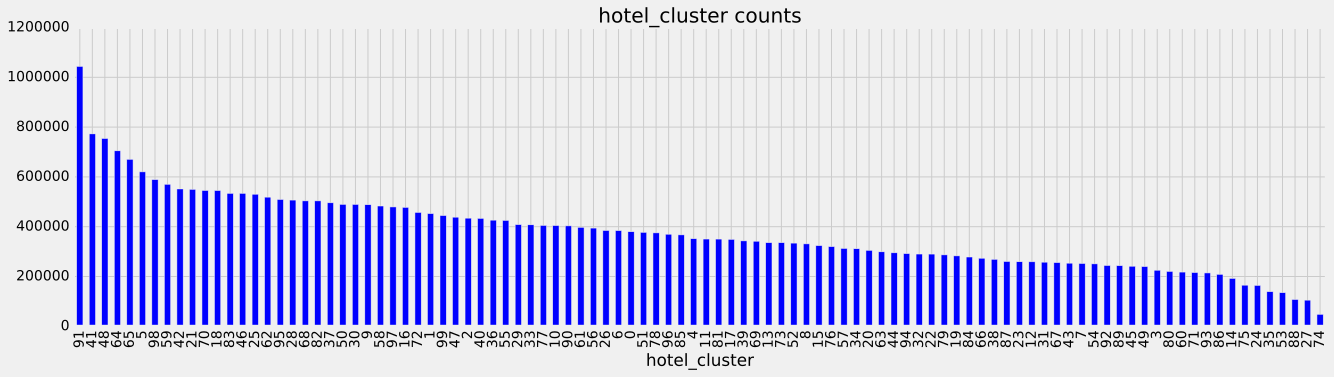

In [138]:
a=5
#gr=(1+np.sqrt(5))/2
gr=4
plt.figure(figsize=[a*gr,a])
hotel_count.plot(kind='bar')
plt.title('hotel_cluster counts')
plt.show()